<a href="https://www.kaggle.com/code/marioayad/cnn-classification?scriptVersionId=127711234" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries


In [11]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D, UpSampling2D, Input, LeakyReLU
from keras.layers import Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.neural_network import MLPClassifier
from keras.utils.vis_utils import plot_model
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import keras
from keras import layers
import random as rnd
import cv2
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Reading Data

In [12]:
main_df = pd.DataFrame()
main_path = '../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

main_df['images'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

classes = []
paths = []
for image in main_df['images']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

main_df['classes'] = classes
main_df['path'] = paths
print(len(main_df))
main_df.head()

500


,images,classes,path
0,Ak (97).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
1,Ak (75).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
2,Ak (16).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
3,Ak (61).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...
4,Ak (95).png,Ak,../input/grapevine-leaves-image-dataset/Grapev...


# Data Split

In [13]:
X_train1, X_test, y_train1, y_test = train_test_split(main_df[['path', 'classes']], 
                                                  main_df[['classes']], 
                                                  test_size=0.2, 
                                                  random_state=101)
X_train, X_val, y_train, y_val = train_test_split(X_train1[['path', 'classes']], 
                                                  X_train1[['classes']], 
                                                  test_size=0.2, 
                                                  random_state=101)
print(len(X_train), len(X_val), len(X_test))

320 80 100


# Showing Images

(511, 511)
(511, 511)
(511, 511)
(511, 511)
(511, 511)


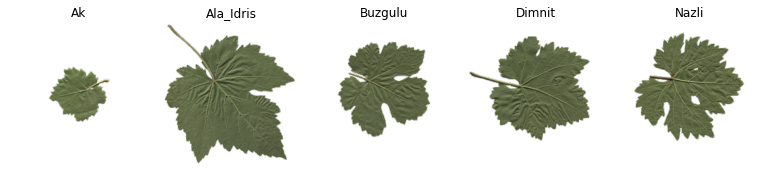

In [14]:
plt.figure(figsize = (15,12))
for idx,i in enumerate(main_df.classes.unique()):
    plt.subplot(4,7,idx+1)
    df = main_df[main_df['classes'] ==i].reset_index(drop = True)
    image_path = df.loc[rnd.randint(0, len(df))-1,'path']
    img = Image.open(image_path)
    print(img.size)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

In [15]:
grape_labels = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
for i in grape_labels:
    print(f"There are {len(os.listdir(os.path.join(main_path, i)))} images of", i)

There are 100 images of Ak
There are 100 images of Ala_Idris
There are 100 images of Buzgulu
There are 100 images of Dimnit
There are 100 images of Nazli


# Callbacks

# Random Seed & Train_Validation_Test Split

In [16]:
main_path = '../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/'
labels = ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli']
Ak_route = main_path + 'Ak'
Ala_Idris_route = main_path + 'Ala_Idris'
Buzgulu_route = main_path + 'Buzgulu'
Dimnit_route = main_path + 'Dimnit'
Nazli_route = main_path + 'Nazli'
count_bar = {}
count_bar['labels'] = labels
count_bar['count'] = [len(os.listdir(main_path+i)) for i in labels]
count_bar_df = pd.DataFrame(count_bar, index=[1,2,3,4,5])

root_dir = "./grape_dataset5"

    
path = os.path.join(root_dir, "training")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))
path = os.path.join(root_dir, "validating")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))
path = os.path.join(root_dir, "testing")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))
def train_test_split(SOURCE, TRAINING, TESTING, VALIDATING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + ' is zero length, so ignoring.')
        
        import random
        from shutil import copyfile

        training_length = int((len(files) * SPLIT_SIZE)*SPLIT_SIZE)
        validating_length = int((len(files) * SPLIT_SIZE)) - training_length
        testing_length = int(len(files) * (1- SPLIT_SIZE))
        shuffled_set = random.sample(files, len(files))
        training_set = shuffled_set[0:training_length]
        validating_set =  shuffled_set[training_length+1:-testing_length]
        testing_set = shuffled_set[-testing_length:]
    for filename in training_set:
        src_file = SOURCE + filename
        dest_file = TRAINING + filename
        copyfile(src_file, dest_file)
    
    for filename in validating_set:
        src_file = SOURCE + filename
        dest_file = VALIDATING + filename
        copyfile(src_file, dest_file)
        
    for filename in testing_set:
        src_file = SOURCE + filename
        dest_file = TESTING + filename
        copyfile(src_file, dest_file)
training_dir = "./grape_dataset5/training"
testing_dir = "./grape_dataset5/testing/"
validating_dir = "./grape_dataset5/validating"
split_size = 0.8

from tensorflow.keras.applications.resnet50 import preprocess_input
for i in range(10):
    for i in labels:
        label_source_dir = "../input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/" + str(i) + "/"
        training_label_dir = os.path.join(training_dir, (str(i)+"/"))
        validating_label_dir = os.path.join(validating_dir, (str(i)+"/"))
        testing_label_dir = os.path.join(testing_dir, (str(i)+"/"))
        train_test_split(label_source_dir, training_label_dir, testing_label_dir, validating_label_dir, split_size)

    resnet50_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.10,brightness_range=[0.6,1.4],channel_shift_range=0.7,width_shift_range=0.15,height_shift_range=0.15,shear_range=0.15,horizontal_flip=True,fill_mode='nearest',preprocessing_function=preprocess_input) 
    train_generator_resnet50 = resnet50_datagen.flow_from_directory(training_dir,  target_size=(227, 227),  batch_size=32,class_mode="categorical",shuffle=True,)
    val_generator_resnet50 = resnet50_datagen.flow_from_directory(validating_dir,  target_size=(227, 227),  batch_size=32,class_mode="categorical",shuffle=True,)
    resnet50_datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input) 
    test_generator_resnet50 = resnet50_datagen_test.flow_from_directory(testing_dir,  target_size=(227, 227),  batch_size=32,class_mode="categorical",shuffle=True,)
    resnet = tf.keras.applications.ResNet50(input_shape=(227,227,3), include_top=False, weights='imagenet', classes=5)
    x = GlobalAveragePooling2D()(resnet.output)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)

    output = Dense(units=5,activation = 'softmax')(x)
    model_resnet = Model(resnet.input, output)



    opt = SGD(lr=0.001)
    model_resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    savebest = tf.keras.callbacks.ModelCheckpoint('resnet_beforefinetuning.h5', save_best_only=True);
    history_resnet = model_resnet.fit(train_generator_resnet50, batch_size = 32,
                                      validation_data=val_generator_resnet50, 
                                      epochs=35, 
                                     callbacks=[early_stopping, plateau],steps_per_epoch=(len(X_train)/32),
          validation_steps=(len(X_val)/32));

    model_resnet.evaluate(test_generator_resnet50)[1]

FileExistsError: [Errno 17] File exists: './grape_dataset5/training'

{'labels': ['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli'], 'count': [100, 100, 100, 100, 100]}


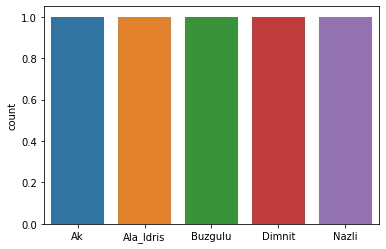

In [17]:
count_bar = {}
count_bar['labels'] = grape_labels
count_bar['count'] = [len(os.listdir(main_path+i)) for i in labels]
print(count_bar)
count_bar_df = pd.DataFrame(count_bar, index=[1,2,3,4,5])
ax = sns.countplot(x=labels, data=count_bar_df)


In [18]:
root_dir = "./grape_dataset2"
import shutil
shutil.rmtree('./grape_dataset2')
    
path = os.path.join(root_dir, "training")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))
path = os.path.join(root_dir, "validating")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))
path = os.path.join(root_dir, "testing")
os.makedirs(path)
for i in labels:
    os.makedirs(os.path.join(path,i))


FileNotFoundError: [Errno 2] No such file or directory: './grape_dataset2'

In [19]:
for i in grape_labels:
    
    print(f"\n\nThere are {len(os.listdir(training_label_dir))} images of", i, "for training")
    print(f"\n\nThere are {len(os.listdir(testing_label_dir))} images of", i, "for testing")




There are 64 images of Ak for training


There are 19 images of Ak for testing


There are 64 images of Ala_Idris for training


There are 19 images of Ala_Idris for testing


There are 64 images of Buzgulu for training


There are 19 images of Buzgulu for testing


There are 64 images of Dimnit for training


There are 19 images of Dimnit for testing


There are 64 images of Nazli for training


There are 19 images of Nazli for testing


In [20]:
os.listdir('./grape_dataset/validating/Ak')

FileNotFoundError: [Errno 2] No such file or directory: './grape_dataset/validating/Ak'

# Data Augmentation

In [21]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  
    
  
    train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')


    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode='categorical',
                                                      target_size=(300, 300))

  
    validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=50,
                                                                class_mode='categorical',
                                                                target_size=(300, 300))

    return train_generator, validation_generator

In [22]:
train_generator, validation_generator = train_val_generators(training_dir, testing_dir)

Found 320 images belonging to 5 classes.
Found 95 images belonging to 5 classes.


# Callbacks

In [23]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 


# Model

In [24]:
model = Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), kernel_initializer="he_uniform", input_shape=(300,300,3), activation="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), kernel_initializer="he_uniform", activation="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), kernel_initializer="he_uniform", activation="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), kernel_initializer="he_uniform", activation="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, kernel_initializer="he_uniform", activation="relu"))
model.add(layers.Dense(units=512, kernel_initializer="he_uniform", activation="relu"))
model.add(layers.Dense(units=64, kernel_initializer="he_uniform", activation="relu"))
model.add(layers.Dense(units=5, kernel_initializer="glorot_uniform", activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 64)      16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 35, 35, 64)        1

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
)

# Transfer Learning

In [26]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

87924736/87910968 [==============================] - 1s 0us/step


In [27]:
inception_v3_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10, 
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)
train_generator_inception_v3 = inception_v3_datagen.flow_from_directory(
        training_dir,  
        target_size=(300, 300),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_inception_v3 = inception_v3_datagen.flow_from_directory(
        validating_dir,  
        target_size=(300, 300),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
inception_v3_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_generator_inception_v3 = inception_v3_datagen_test.flow_from_directory(
        testing_dir,  
        target_size=(300, 300),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 95 images belonging to 5 classes.


In [28]:
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output  = layers.Dense(units=5, activation='softmax')(x)
model_inception = Model(InceptionV3_model.input, output)

model_inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"])
history_inception = model_inception.fit(train_generator_inception_v3, steps_per_epoch=4, epochs=25, validation_data=val_generator_inception_v3, validation_steps=2)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

NameError: name 'history_inception' is not defined

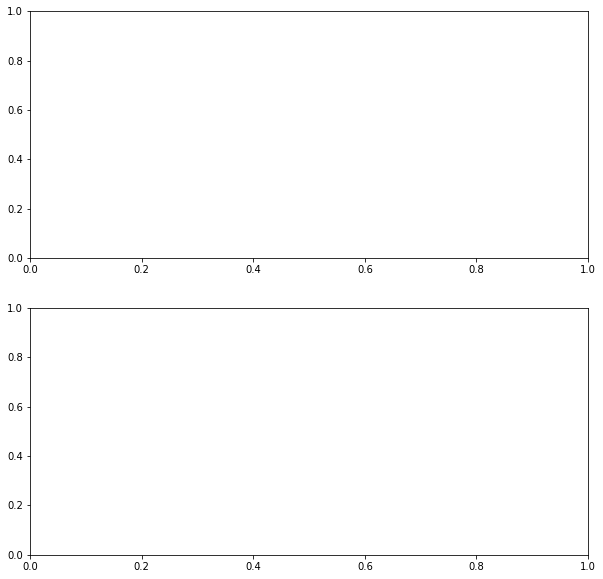

In [30]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

ax[0].plot(history_inception.history['loss'],label='Training Loss')
ax[0].plot(history_inception.history['val_loss'],label='Validation Loss')

ax[1].plot(history_inception.history['accuracy'],label='Training Accuracy')
ax[1].plot(history_inception.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [31]:
num_of_test_samples = 100
batch_size = 32
Y_pred_inc = model_inception.predict_generator(test_generator_inception_v3, num_of_test_samples // batch_size+1)
y_pred_inc = np.argmax(Y_pred_inc, axis=1)
print('Confusion Matrix')
conf_matrix_inc = confusion_matrix(test_generator_inception_v3.classes, y_pred_inc)
cm_inc = np.array2string(conf_matrix_inc)
print(conf_matrix_inc)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 0  0  0 19  0]
 [ 0  2  1 16  0]
 [ 0  0  0 19  0]
 [ 0  2  0 17  0]
 [ 0  1  1 17  0]]


In [ ]:
from statistics import mean
inception_v3_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10, 
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)
inception_v3_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
results_inc = []

Y = X_train1[['classes']]

for train_index, val_index in kf.split(np.zeros(400),Y):
    training_data = X_train1.iloc[train_index]
    validation_data = X_train1.iloc[val_index]
    training_set = inception_v3_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)
    validation_set = inception_v3_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    
    InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    for layer in InceptionV3_model.layers[:-15]:
        layer.trainable = False
    x = InceptionV3_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.3)(x)
    output  = Dense(units=5, activation='softmax')(x)
    model_inception = Model(InceptionV3_model.input, output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model_inception.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])
    history_inception = model_inception.fit(train_generator_inception_v3, steps_per_epoch=4, epochs=25, validation_data=val_generator_inception_v3, validation_steps=2)
    
    resu = model_inception.evaluate(test_generator_inception_v3)
    results_inc.append(resu)
    print(resu)
print(results_inc)

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Epoch 1/25
4/4 [==============================] - 34s 8s/step - loss: 5.6655 - accuracy: 0.2188 - val_loss: 6.4271 - val_accuracy: 0.2188
Epoch 2/25
4/4 [==============================] - 24s 6s/step - loss: 3.6919 - accuracy: 0.2422 - val_loss: 4.6864 - val_accuracy: 0.2812
Epoch 3/25
4/4 [==============================] - 24s 6s/step - loss: 3.1814 - accuracy: 0.2031 - val_loss: 3.1268 - val_accuracy: 0.1406
Epoch 4/25
4/4 [==============================] - 24s 7s/step - loss: 2.3625 - accuracy: 0.1719 - val_loss: 2.8149 - val_accuracy: 0.1719
Epoch 5/25
4/4 [==============================] - 24s 6s/step - loss: 2.0679 - accuracy: 0.1953 - val_loss: 1.7215 - val_accuracy: 0.1875
Epoch 6/25
4/4 [==============================] - 24s 6s/step - loss: 1.8769 - accuracy: 0.2188 - val_loss: 1.7408 - val_accuracy: 0.2812
Epoch 7/25
4/4 [==============================] - 24s

# ResNet50 after fine tuning

In [ ]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 
train_generator_resnet50 = resnet50_datagen.flow_from_directory(
        training_dir,  
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_directory(
        validating_dir,  
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
resnet50_datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
) 
test_generator_resnet50 = resnet50_datagen_test.flow_from_directory(
        testing_dir,  
        target_size=(227, 227),  
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape=(227,227,3), include_top=False, weights='imagenet', classes=5)

x = GlobalAveragePooling2D()(resnet.output)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(units=5,activation = 'softmax')(x)
model_resnet = Model(resnet.input, output)
model_resnet.summary()

In [ ]:
opt = SGD(lr=0.001)
model_resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
savebest = tf.keras.callbacks.ModelCheckpoint('resnet_beforefinetuning.h5', save_best_only=True);
history_resnet = model_resnet.fit(train_generator_resnet50, 
                                  validation_data=val_generator_resnet50, 
                                  epochs=35, 
                                 callbacks=[savebest])

In [ ]:
model_resnet.evaluate(test_generator_resnet50)[1]

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

ax[0].plot(history_resnet.history['loss'],label='Training Loss')
ax[0].plot(history_resnet.history['val_loss'],label='Validation Loss')


ax[1].plot(history_resnet.history['accuracy'],label='Training Accuracy')
ax[1].plot(history_resnet.history['val_accuracy'],label='Validation Accuracy')

plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
num_of_test_samples = 100
batch_size = 32
Y_pred_res = model_resnet.predict_generator(test_generator_resnet50, num_of_test_samples // batch_size+1)
y_pred_res = np.argmax(Y_pred_res, axis=1)
print('Confusion Matrix')
conf_matrix_res = confusion_matrix(test_generator_resnet50.classes, y_pred_res)
cm_res = np.array2string(conf_matrix_res)
print(conf_matrix_res)

In [ ]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

kf = KFold(n_splits = 10)
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
results = []

Y = X_train1[['classes']]
train_x = X_train1.drop(['classes'],axis=1)

for train_index, val_index in kf.split(np.zeros(400),Y):
    training_data = X_train1.iloc[train_index]
    validation_data = X_train1.iloc[val_index]
    training_set = resnet50_datagen.flow_from_dataframe(dataframe = training_data, 
                                                      x_col="path", 
                                                      y_col="classes",
                                                      class_mode="categorical",
                                                      target_size=(227, 227), 
                                                      batch_size=32)
    validation_set = resnet50_datagen.flow_from_dataframe(dataframe = validation_data, 
                                                        x_col = "path", 
                                                        y_col = "classes",
                                                        class_mode = "categorical",
                                                        target_size = (227, 227), 
                                                        batch_size = 32)
    resnet = tf.keras.applications.ResNet50(input_shape=(227,227,3), include_top=False, weights='imagenet', classes=5)
    x = GlobalAveragePooling2D()(resnet.output)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(units=5,activation = 'softmax')(x)
    model_resnet = Model(resnet.input, output)

In [ ]:
opt = SGD(lr=0.001)
model_resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
history_resnet = model_resnet.fit(training_set, validation_data=validation_set, epochs=30)
resu = model_resnet.evaluate(test_generator_resnet50)
results.append(resu)
print(resu)
print(results)